In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import pandas as pd
import photutils

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from astropy.stats import mad_std

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth



In [2]:
#Setup notebook so Tensorflow works in a friendly way in a shared multi GPU env

def setup_tensorflow(seed=None):
    try:
        import nvsmi

        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)
    

In [3]:
setup_tensorflow()

Using GPU: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2022-04-21 18:31:08.505662: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 18:31:12.766159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9335 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [4]:

#load the image arrays 

blends = np.load("blends.npy")
components = np.load("components.npy")


In [5]:
#Split into training and test set 

#Going to split training and test 80% and 20% respectively 

train_ngals = int(blends.shape[0] * 0.8)
test_ngals = int(blends.shape[0] * 0.2)

train_blends = blends[:train_ngals]
test_blends = blends[train_ngals:]

a, b, c, d, test_components = np.split(components, 5, axis = 1)
train_components = np.concatenate((a, b, c, d), axis = 1)




In [6]:
blends.shape, train_blends.shape, test_blends.shape

((120000, 64, 64), (96000, 64, 64), (24000, 64, 64))

In [7]:
components.shape, train_components.shape, test_components.shape

((2, 120000, 64, 64), (2, 96000, 64, 64), (2, 24000, 64, 64))

In [8]:

#Normalise the data

#Blends

train_blends_max = np.amax(train_blends)
train_blends_min = np.amin(train_blends)

train_blends = (train_blends - train_blends_min) / (train_blends_max - train_blends_min) 

test_blends_max = np.amax(test_blends)
test_blends_min = np.amin(test_blends)

test_blends = (test_blends - test_blends_min) / (test_blends_max - test_blends_min) 

#Components

train_components_max = np.amax(train_components) 
train_components_min = np.amin(train_components)

train_components = (train_components - train_components_min) / (train_components_max - train_components_min) 

test_components_max = np.amax(test_components) 
test_components_min = np.amin(test_components)

test_components = (test_components - test_components_min) / (test_components_max - test_components_min) 



In [9]:
np.amax(train_blends), np.amin(train_blends), np.amax(test_blends), np.amin(test_blends)

(1.0, 0.0, 1.0, 0.0)

In [10]:
np.amax(test_components), np.amin(test_components), np.amax(test_blends), np.amin(test_blends)

(1.0, 0.0, 1.0, 0.0)

In [11]:
height,width=64,64

train_blends = train_blends.reshape(train_ngals, height, width, 1).astype('float32')
train_components = train_components.reshape(2, train_ngals, height, width, 1).astype('float32')

test_blends = test_blends.reshape(test_ngals, height, width, 1).astype('float32')
test_components = test_components.reshape(2, test_ngals, height, width, 1).astype('float32')


In [12]:
batch_size = 32
latent_dimensions = 32

In [13]:
blends.shape, components.shape

((120000, 64, 64), (2, 120000, 64, 64))

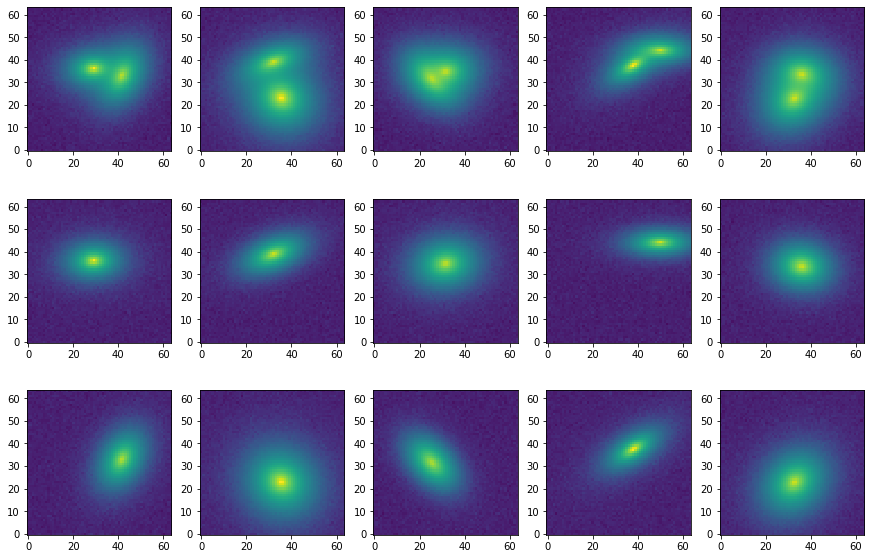

In [14]:
fig, ax = plt.subplots(2 + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(train_blends[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
    ax[1, i].imshow(train_components[0, i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
    ax[2, i].imshow(train_components[1, i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)

In [15]:
#Will optimise encoder / decoder later
def encoder(x):
    x=Conv2D(32,3,activation='relu', strides = 2, padding='same')(x)
    x=Conv2D(64,3,activation='relu', strides = 2, padding='same')(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [16]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu', strides = 2 ,padding='same')(x)
    x=Conv2DTranspose(32,3,activation='relu', strides = 2 ,padding='same')(x)
    return x

In [17]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [18]:
# encoder
input_blend=Input(shape=(height, width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [19]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

embed2=Dense(np.prod(shape),activation='relu')(input_embed)
embed2=Reshape(shape)(embed2)
decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [20]:
encode=Model(input_blend,z)
encode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 16384)        0           ['conv2d_1[0][0]']               
                                                                                              

In [21]:
input_component1 = Input(shape=(height, width, 1))
input_component2 = Input(shape=(height, width, 1))

decode=Model([input_embed, input_component1, input_component2], [output1, output2])
decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 16384)        540672      ['input_2[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 16384)        540672      ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 16, 16, 64)   0           ['dense_2[0][0]']                
                                                                                            

In [22]:
encoding = encode(input_blend)
re1, re2 = decode([encoding, input_component1, input_component2])

vae = Model([input_blend, input_component1, input_component2], [re1, re2])

In [23]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 32)           1067456     ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                            

In [24]:
blends.shape, components.shape 

((120000, 64, 64), (2, 120000, 64, 64))

In [25]:
mse_lossA = mse(input_component1, re1) + mse(input_component2, re2)
mse_lossA = tf.reduce_mean(mse_lossA / 2, axis=(1, 2))
mse_lossB = mse(input_component1, re2) + mse(input_component2, re1)
mse_lossB = tf.reduce_mean(mse_lossB / 2, axis=(1, 2))
mse_loss = tf.reduce_mean(tf.minimum(mse_lossA, mse_lossB)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*0.1
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')


train_together = [train_blends, train_components[0], train_components[1]]
test_together = [test_blends, test_components[0], test_components[1]]

vae.compile(optimizer=Adam())

In [26]:
history=vae.fit(train_together, verbose = 1, epochs = 100, batch_size = batch_size, validation_split = 0.2)

Epoch 1/100


2022-04-21 18:37:52.679064: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


2400/2400 [==============================] - 55s 17ms/step - loss: 6.2599 - mse_loss: 5.9873 - kl_loss: 0.2725 - val_loss: 3.6043 - val_mse_loss: 3.2966 - val_kl_loss: 0.3078
Epoch 2/100
2400/2400 [==============================] - 37s 15ms/step - loss: 3.2140 - mse_loss: 2.9070 - kl_loss: 0.3070 - val_loss: 2.8524 - val_mse_loss: 2.5473 - val_kl_loss: 0.3051
Epoch 3/100
2400/2400 [==============================] - 36s 15ms/step - loss: 2.6856 - mse_loss: 2.3844 - kl_loss: 0.3011 - val_loss: 2.5777 - val_mse_loss: 2.2845 - val_kl_loss: 0.2932
Epoch 4/100
2400/2400 [==============================] - 37s 15ms/step - loss: 2.4368 - mse_loss: 2.1389 - kl_loss: 0.2979 - val_loss: 2.4341 - val_mse_loss: 2.1427 - val_kl_loss: 0.2914
Epoch 5/100
2400/2400 [==============================] - 36s 15ms/step - loss: 2.2924 - mse_loss: 1.9972 - kl_loss: 0.2952 - val_loss: 2.3224 - val_mse_loss: 2.0353 - val_kl_loss: 0.2871
Epoch 6/100
2400/2400 [==============================] - 37s 15ms/step - loss

In [27]:
def histplot(history):
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = f'Minimum Validation Loss: {min(val_loss):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

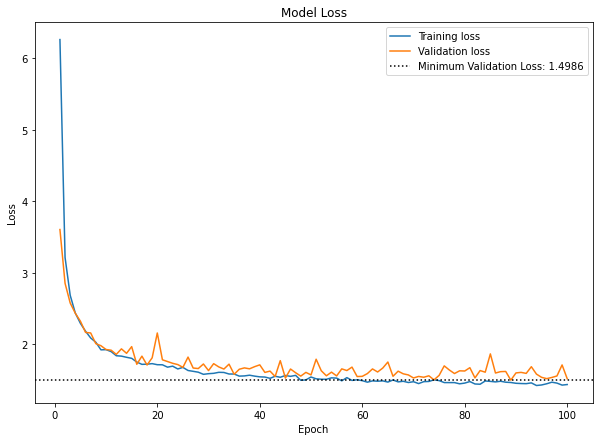

In [28]:
histplot(history)

In [29]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    fig, ax = plt.subplots(7, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[0, i].set_title('Input Blend')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[1, i].set_title('Input Component 1')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[2, i].set_title('Input Component 2')
        ax[3, i].imshow(output_img1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[3, i].set_title('Reconstruction Component 1')
        ax[3, i].set_xlabel(f'MSE: {mean_squared_error(comp1[i], output_img1[i]):.2f}, SSIM: {ssim(comp1[i], output_img1[i], channel_axis = 2):.2f}')
        ax[4, i].imshow(output_img2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[4, i].set_title('Reconstruction Component 2')
        ax[5, i].imshow((output_img1[i] + output_img2[i]) , origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[5, i].set_title('Reconstruction Blend')
        ax[4, i].set_xlabel(f'MSE: {mean_squared_error(comp2[i], output_img2[i]):.2f}, SSIM: {ssim(comp2[i], output_img2[i], channel_axis = 2):.2f}')
        ax[6, i].imshow(abs(input_img[i] -(output_img1[i] + output_img2[i])) , origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[6, i].set_title('Blend Difference')
        plt.tight_layout()
    return idx

[ 6414 13523  8374  5256  4405]


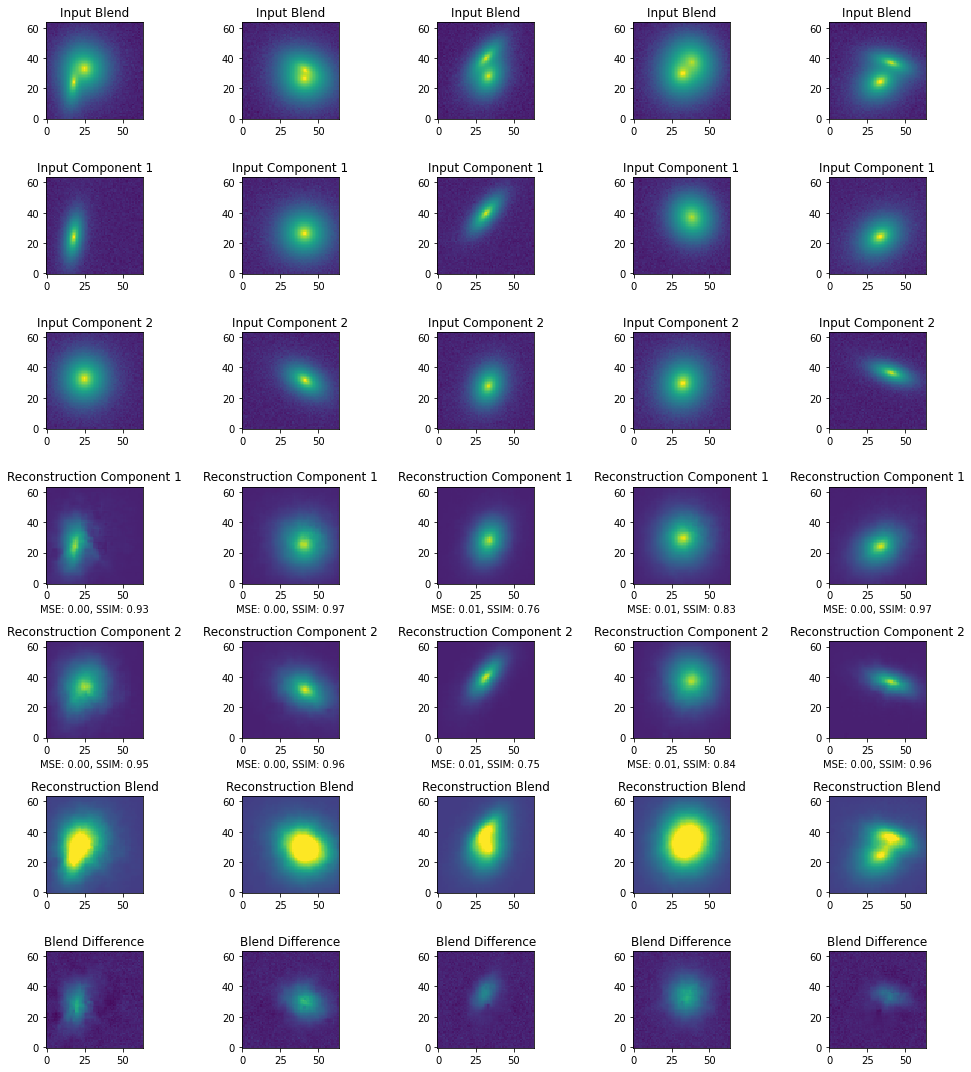

In [30]:
n=5
chosen=summary_plot(n,test_together,decode)

In [31]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(test_ngals)
    ssim_comp2 = np.zeros(test_ngals)
    ssim_blends = np.zeros(test_ngals)
    input_img = inputs[0]
    comp1 = inputs[1]
    comp2 = inputs[2]
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    for i in range(test_ngals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis = 2)
        ssim_comp2[i] = ssim(comp2[i], output_img2[i], channel_axis = 2)
        ssim_blends[i] = ssim(input_img[i], (output_img1[i] + output_img2[i]), channel_axis = 2)
    mean_ssim_comp1 = np.mean(ssim_comp1)
    median_ssim_comp1 = np.median(ssim_comp1)
    
    mean_ssim_comp2 = np.mean(ssim_comp2)
    median_ssim_comp2 = np.median(ssim_comp2)
    
    mean_ssim_blends = np.mean(ssim_blends)
    median_ssim_blends = np.median(ssim_blends)
    
    ssim_values = np.array([mean_ssim_comp1, median_ssim_comp1, mean_ssim_comp2, median_ssim_comp2, mean_ssim_blends, median_ssim_blends])
    
    return ssim_values 
        
        
        

    
    

In [32]:
ssim_values = calc_ssim(test_together, decode)


In [33]:
mean_ssim_comp1 = ssim_values[0]
median_ssim_comp1 = ssim_values[1]
mean_ssim_comp2 = ssim_values[2]
median_ssim_comp2 = ssim_values[3]
mean_ssim_blends = ssim_values[4]
median_ssim_blends = ssim_values[5]

In [34]:
print(f' Mean SSIMs: Component 1: {mean_ssim_comp1:.4f}, Component 2: {mean_ssim_comp2:.4f}, Blends: {mean_ssim_blends:.4f}')

print(f' Median SSIMs: Component 1: {median_ssim_comp1:.4f}, Component 2: {median_ssim_comp2:.4f}, Blends: {median_ssim_blends:.4f}')


 Mean SSIMs: Component 1: 0.8583, Component 2: 0.8587, Blends: 0.8405
 Median SSIMs: Component 1: 0.9209, Component 2: 0.9208, Blends: 0.8415


In [35]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(test_ngals)
    
    flux_in_comp1 = np.zeros(test_ngals)
    flux_in_comp2 = np.zeros(test_ngals)
    flux_in_blends = np.zeros(test_ngals)
    
    flux_out_comp1 = np.zeros(test_ngals)
    flux_out_comp2 = np.zeros(test_ngals)
    flux_out_blends = np.zeros(test_ngals)
    
    
    elip_in_comp1 = np.zeros(test_ngals)
    elip_in_comp2 = np.zeros(test_ngals)
    
    elip_out_comp1 = np.zeros(test_ngals)
    elip_out_comp2 = np.zeros(test_ngals)
    
    input_img = inputs[0]
    input_img = input_img.reshape(test_ngals, height, width)
    comp1 = inputs[1]
    comp1 = comp1.reshape(test_ngals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(test_ngals, height,width)
    z = encode.predict(input_img)
    output_img1, output_img2 = decode.predict([z, comp1, comp2])
    
    output_img1 = output_img1.reshape(test_ngals, height, width)
    output_img2 = output_img2.reshape(test_ngals, height, width)
    
    for i in range(test_ngals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
  
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
        
        in_blends_cat = photutils.morphology.data_properties(input_img[i], mask = None, background = 0)
        flux_in_blends[i] = in_blends_cat.segment_flux

            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        out_comp2_cat = photutils.morphology.data_properties(output_img2[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        out_blends_cat = photutils.morphology.data_properties((output_img1[i] + output_img2[i]), mask = None, background = 0)
        flux_out_blends[i] = out_blends_cat.segment_flux
        
        parameters = [elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2, flux_in_blends, flux_out_blends]   
    return parameters


        

In [36]:
parameters = calc_properties(test_together, decode)

In [37]:

ellip_in_comp1 = parameters[0]
ellip_out_comp1 = parameters[1]
flux_in_comp1 = parameters[2]
flux_out_comp1 = parameters[3]
ellip_in_comp2 = parameters[4]
ellip_out_comp2 = parameters[5]
flux_in_comp2 = parameters[6]
flux_out_comp2 = parameters[7]
flux_in_blends = parameters[8]
flux_out_blends = parameters[9]


In [38]:
#Calculate the standard deviations 
def calc_std(parameters):
    num_of_params = len(parameters)
    standard_dev_of_params = np.zeros(num_of_params)
    for i in range(0,num_of_params):
        standard_dev_of_params[i] = np.std(parameters[i])
    return standard_dev_of_params



In [39]:
std_of_params = calc_std(parameters)


In [40]:
print(f'Std dev of Ellip: Comp1 [In] {std_of_params[0]:.4f}, Comp1 [Out] {std_of_params[1]:.4f}, Comp2 [In] {std_of_params[4]:.4f}, Comp2 [Out] {std_of_params[5]:.4f} ')
print(f'Std dev of Flux: Comp1 [In] {std_of_params[2]:.4f}, Comp1 [Out] {std_of_params[3]:.4f}, Comp2 [In] {std_of_params[6]:.4f}, Comp2 [Out] {std_of_params[7]:.4f}, Blend [In] {std_of_params[8]:.4f}, Blend [Out] {std_of_params[9]:.4f} ')

Std dev of Ellip: Comp1 [In] 0.0314, Comp1 [Out] 0.0308, Comp2 [In] 0.0313, Comp2 [Out] 0.0319 
Std dev of Flux: Comp1 [In] 97.1007, Comp1 [Out] 89.3276, Comp2 [In] 96.9265, Comp2 [Out] 92.5814, Blend [In] 107.3111, Blend [Out] 137.5504 


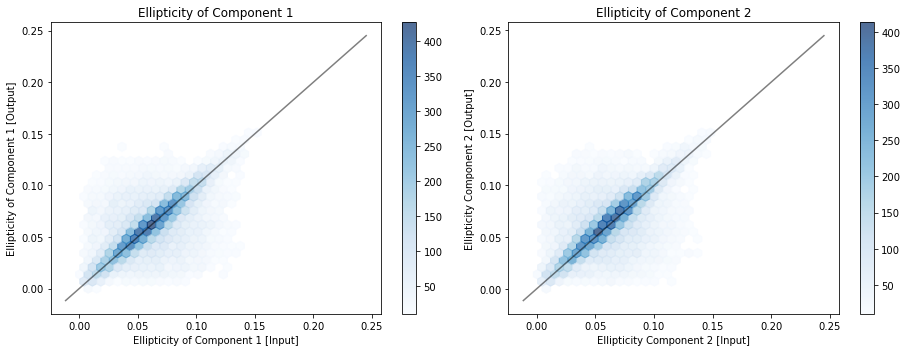

In [41]:
fig, axes = plt.subplots(1, 2, figsize = (13,5))

axes[0].set_title("Ellipticity of Component 1")
hex1 = axes[0].hexbin(ellip_in_comp1, ellip_out_comp1, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[0].set_xlabel("Ellipticity of Component 1 [Input]")
axes[0].set_ylabel("Ellipticity of Component 1 [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Ellipticity of Component 2")
hex2 = axes[1].hexbin(ellip_in_comp2, ellip_out_comp2, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[1].set_xlabel("Ellipticity Component 2 [Input]")
axes[1].set_ylabel("Ellipticity Component 2 [Output]")
fig.colorbar(hex2, ax=axes[1])

lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(lims, lims, 'k-', alpha=0.5, zorder=1)


fig.tight_layout()

plt.show()

[299.16051851180197, 1716.6973398610949]


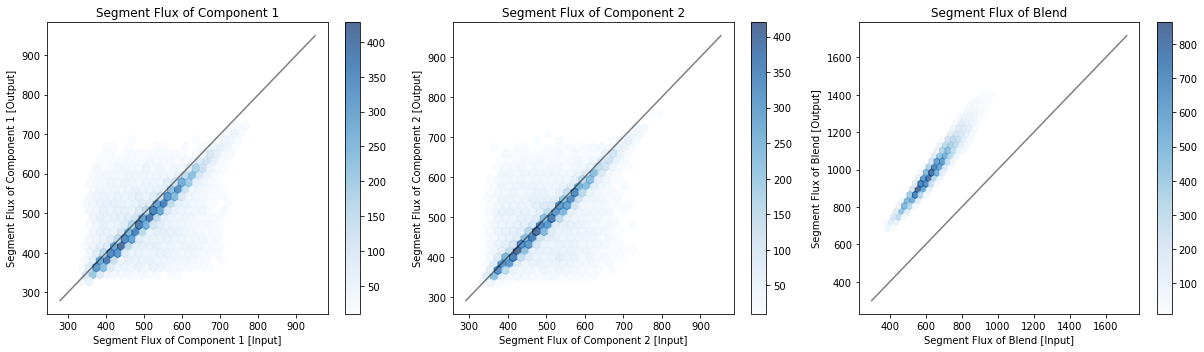

In [42]:

fig, axes = plt.subplots(1, 3, figsize = (17,5))

axes[0].set_title("Segment Flux of Component 1")
hex1 = axes[0].hexbin(flux_in_comp1, flux_out_comp1, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[0].set_xlabel("Segment Flux of Component 1 [Input]")
axes[0].set_ylabel("Segment Flux of Component 1 [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Segment Flux of Component 2")
hex2 = axes[1].hexbin(flux_in_comp2, flux_out_comp2, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[1].set_xlabel("Segment Flux of Component 2 [Input]")
axes[1].set_ylabel("Segment Flux of Component 2 [Output]")
fig.colorbar(hex2, ax=axes[1])

lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[2].set_title("Segment Flux of Blend")
hex3 = axes[2].hexbin(flux_in_blends, flux_out_blends, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[2].set_xlabel("Segment Flux of Blend [Input]")
axes[2].set_ylabel("Segment Flux of Blend [Output]")
fig.colorbar(hex3, ax=axes[2])

lims = [
    np.min([axes[2].get_xlim(), axes[2].get_ylim()]),  # min of both axes
    np.max([axes[2].get_xlim(), axes[2].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[2].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

fig.tight_layout()

plt.show()

In [45]:


# Calculate accuracys 

ellip_comp1_accuracy = abs(ellip_out_comp1 / ellip_in_comp1) * 100
mean_ellip_comp1_accuracy = np.mean(ellip_comp1_accuracy)
median_ellip_comp1_accuracy = np.median(ellip_comp1_accuracy)

flux_comp1_accuracy = abs(flux_out_comp1 / flux_in_comp1) * 100
mean_flux_comp1_accuracy = np.mean(flux_comp1_accuracy)
median_flux_comp1_accuracy = np.median(flux_comp1_accuracy)

ellip_comp2_accuracy = abs(ellip_out_comp2 / ellip_in_comp2) * 100
mean_ellip_comp2_accuracy = np.mean(ellip_comp2_accuracy)
median_ellip_comp2_accuracy = np.median(ellip_comp2_accuracy)

flux_comp2_accuracy = abs(flux_out_comp2 / flux_in_comp2) * 100
mean_flux_comp2_accuracy = np.mean(flux_comp2_accuracy)
median_flux_comp2_accuracy = np.median(flux_comp2_accuracy)

flux_blend_accuracy = abs(flux_out_blends / flux_in_blends) * 100 
mean_flux_blend_accuracy = np.mean(flux_blend_accuracy)
median_flux_blend_accuracy = np.median(flux_blend_accuracy)


In [46]:
print(f' Mean ellipticity accuracys: Component 1: {mean_ellip_comp1_accuracy :.4f}, Component 2: {mean_ellip_comp2_accuracy:.4f}')
print(f' Median ellipticity accuracys: Component 1: {median_ellip_comp1_accuracy:.4f}, Component 2: {median_ellip_comp2_accuracy:.4f} \n')

print(f' Mean flux accuracys: Component 1: {mean_flux_comp1_accuracy:.4f}, Component 2: {mean_flux_comp2_accuracy:.4f}, Blends: {mean_flux_blend_accuracy:.4f}')
print(f' Median flux accuracys: Component 1: {median_flux_comp1_accuracy:.4f}, Component 2: {median_flux_comp2_accuracy:.4f}, Blends: {median_flux_blend_accuracy:.4f}')

 Mean ellipticity accuracys: Component 1: 131.2147, Component 2: 135.8932
 Median ellipticity accuracys: Component 1: 100.4832, Component 2: 103.3073 

 Mean flux accuracys: Component 1: 97.5624, Component 2: 99.3344, Blends: 156.8030
 Median flux accuracys: Component 1: 95.7353, Component 2: 97.3965, Blends: 156.6169
